In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np #linear algebra
import matplotlib.pyplot as plt
import pandas as pd # data processing
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/swahili-news-classification-v2/SampleSubmission.csv
/kaggle/input/swahili-news-classification-v2/Train.csv
/kaggle/input/swahili-news-classification-v2/Test.csv


# Loading data

In [2]:
df = pd.read_csv('/kaggle/input/swahili-news-classification-v2/Train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5151 entries, 0 to 5150
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5151 non-null   object
 1   content   5151 non-null   object
 2   category  5151 non-null   object
dtypes: object(3)
memory usage: 120.9+ KB


In [3]:
df_test = pd.read_csv('/kaggle/input/swahili-news-classification-v2/Test.csv')

In [4]:
df.head()

,id,content,category
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


In [5]:
df.category.value_counts()

Kitaifa      2000
michezo      1720
Biashara     1360
Kimataifa      54
Burudani       17
Name: category, dtype: int64

In [6]:
ratio_Kitaifa = 2000./(200+1720+1360+54+17)
ratio_michezo = 1720./(200+1720+1360+54+17)
ratio_Biashara = 1360./(200+1720+1360+54+17)
ratio_Kimataifa = 54./(200+1720+1360+54+17)
ratio_Burudani = 17./(200+1720+1360+54+17)
train_ratio = 0.6
valid_ratio = 0.2
test_ratio = 0.2
np.random.seed(42)

In [7]:
def stratified_sampling_split(proportions, dataset):
  """
  perform stratified sampling from dataset to split between train, valid, and test
  proportions: a dict with train, valid, and test proportions
  dataset: pandas DataFrame
  returns train, valid, test
  """

  # Perform stratified sampling for train set
  train_df, remaining_df = train_test_split(dataset, train_size=proportions['train'], stratify=dataset['category'])

  # Perform stratified sampling for validation and test sets
  validation_df, test_df = train_test_split(remaining_df, train_size=proportions['valid']/(proportions['valid'] + proportions['test']), stratify=remaining_df['category'])
  return train_df,validation_df,test_df



In [8]:
train_df,validation_df,test_df = stratified_sampling_split({'train': 0.6,'valid':0.2, 'test':0.2}, df)

# Text pre-processing

In [9]:
pd.set_option('display.max_colwidth', True)

In [10]:
print(df['content'].head())

0     SERIKALI imesema haitakuwa tayari kuona amani na utulivu wa nchi inachezewa huku ikisisitiza uwepo wa umoja kati ya wananchi bila kujali tofauti ya imani, kabila au itikadi yoyote.Hayo yalisemwa na Naibu Waziri wa Mambo ya Ndani ya Nchi, Hamad Yussuf Masauni wakati akifungua semina ya siku mbili iliyofanyika jijini Dar es Salaam ikiwahusisha viongozi wa taasisi za Kiislamu, lengo ikiwa ni kuwakumbusha kuhubiri amani katika sehemu zao.Naibu Waziri amesema mwelekeo na malengo ya Serikali ya Awamu ya Tano ni kukuza maendeleo katika sehemu mbalimbali nchini lengo ikiwa kuinua maisha ya wananchi na nchi kwa ujumla.“Serikali hii imejidhatiti kuhakikisha maendeleo yanakuja kwa kasi na maendeleo hayawezi kuja ikiwa amani na utulivu haupo, sisi kama serikali tutahakikisha tunalinda amani iliyopo ili wananchi wapate kufanya shughuli za kiuchumi bila wasiwasi wowote,” amesema Masauni.Akizungumza wakati wa ufunguzi huo, Shehe wa Mkoa wa Dar es Salaam, Alhaji Alhad Mussa Salum aliihakikishia 

Below clean_text function from https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17 by Susan Li

In [11]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    return text

In [12]:
df['content'] = df['content'].apply(clean_text)
df['content'] = df['content'].str.replace('\d+', '')

/tmp/ipykernel_32/189224010.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['content'] = df['content'].str.replace('\d+', '')


In [13]:
df_test['content'] = df_test['content'].apply(clean_text)
df_test['content'] = df_test['content'].str.replace('\d+', '')

/tmp/ipykernel_32/282322481.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['content'] = df_test['content'].str.replace('\d+', '')


In [14]:
print(df['content'].head())


0     serikali imesema haitakuwa tayari kuona amani na utulivu wa nchi inachezewa huku ikisisitiza uwepo wa umoja kati ya wananchi bila kujali tofauti ya imani  kabila au itikadi yoyotehayo yalisemwa na naibu waziri wa mambo ya ndani ya nchi  hamad yussuf masauni wakati akifungua semina ya siku mbili iliyofanyika jijini dar es salaam ikiwahusisha viongozi wa taasisi za kiislamu  lengo ikiwa ni kuwakumbusha kuhubiri amani katika sehemu zaonaibu waziri amesema mwelekeo na malengo ya serikali ya awamu ya tano ni kukuza maendeleo katika sehemu mbalimbali nchini lengo ikiwa kuinua maisha ya wananchi na nchi kwa ujumlaserikali hii imejidhatiti kuhakikisha maendeleo yanakuja kwa kasi na maendeleo hayawezi kuja ikiwa amani na utulivu haupo  sisi kama serikali tutahakikisha tunalinda amani iliyopo ili wananchi wapate kufanya shughuli za kiuchumi bila wasiwasi wowote  amesema masauniakizungumza wakati wa ufunguzi huo  shehe wa mkoa wa dar es salaam  alhaji alhad mussa salum aliihakikishia serika

In [15]:
print(df_test['content'].head())


0     mkuu wa wilaya ya bahi  mkoani dodoma  mwanahamisi munkunda ameuagiza uongozi wa halmashauri ya wilaya hiyo na kamati zote za usimaminzi wa ujenzi wa mradi wa hospitali yao kukamilisha ujenzi mei   mwaka huualitoa agizo hilo mwishoni mwa wiki wakati akizindua eneo itakapokengwa hospitali hiyo alisema kutokana na maandalizi yote ya msingi ikiwemo ununuzi wa vifaa vya ujenzi  bati  nondo mchanga  kukamilika  hakuna sababu inayoweza kukwamisha ujenzi huo  nataka mradi huu kukamilika mei   mwaka huu  kutokana na vifaa vyote kukamilika tuwe tumekamilisha majengo yote saba  alisemaalisema hivyo kwa sababu anaamini nguvu ya wananchi ipo na viongozi wameshaamua sasa tunasubiri nini na taratibu zote za kisheria ambazo tulipaswa kuzifuata zimekwishakamilika  alisema mkuu huyoalizitaka kamati hizo na askari wa jeshi la akiba kutoa taarifa kwa mtu yeyote au kamati itakayobainika ikuhujumu fedha za ujenzi wa mradi huo hatua kali za kisheria zichukuliwe aliwataka wananchi wa wilaya hiyo kuwa n

In [16]:
train_df,validation_df,test_df = stratified_sampling_split({'train': 0.6,'valid':0.2, 'test':0.2}, df)

# Data pre-processing

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [18]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 412
EMBEDDING_DIM = 256
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 96039 unique tokens.


In [19]:
X_train = tokenizer.texts_to_sequences(train_df['content'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (3090, 412)


In [20]:
y_train = pd.get_dummies(train_df['category']).values
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (3090, 5)


In [21]:
tokenizer_test = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer_test.fit_on_texts(df_test['content'].values)
word_index_test = tokenizer_test.word_index
print('Found %s unique tokens.' % len(word_index_test))

Found 38225 unique tokens.


In [22]:
X_val = tokenizer.texts_to_sequences(validation_df['content'].values)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_val.shape)
y_val = pd.get_dummies(validation_df['category']).values
print('Shape of label tensor:', y_val.shape)

Shape of data tensor: (1030, 412)
Shape of label tensor: (1030, 5)


In [23]:
X_test = tokenizer.texts_to_sequences(test_df['content'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)
y_test = pd.get_dummies(test_df['category']).values
print('Shape of label tensor:', y_test.shape)

Shape of data tensor: (1031, 412)
Shape of label tensor: (1031, 5)


In [24]:
X_test_final = tokenizer.texts_to_sequences(df_test['content'].values)
X_test_final = pad_sequences(X_test_final, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test_final.shape)

Shape of data tensor: (1288, 412)


# LSTM model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [26]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.1))
#tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
model.add(tf.keras.layers.Bidirectional(LSTM(EMBEDDING_DIM)))
#model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(EMBEDDING_DIM, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

In [28]:
epochs = 10
batch_size = 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split= 0.2, callbacks=[checkpoint, early_stopping])
#history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val,y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/10
39/39 [==============================] - ETA: 0s - loss: 1.1401 - accuracy: 0.4272
Epoch 1: val_accuracy improved from -inf to 0.68123, saving model to best_model.h5
39/39 [==============================] - 134s 3s/step - loss: 1.1401 - accuracy: 0.4272 - val_loss: 0.7227 - val_accuracy: 0.6812
Epoch 2/10
39/39 [==============================] - ETA: 0s - loss: 0.6146 - accuracy: 0.7265
Epoch 2: val_accuracy did not improve from 0.68123
39/39 [==============================] - 127s 3s/step - loss: 0.6146 - accuracy: 0.7265 - val_loss: 0.7218 - val_accuracy: 0.6780
Epoch 3/10
39/39 [==============================] - ETA: 0s - loss: 0.3400 - accuracy: 0.8896
Epoch 3: val_accuracy improved from 0.68123 to 0.80744, saving model to best_model.h5
39/39 [==============================] - 127s 3s/step - loss: 0.3400 - accuracy: 0.8896 - val_loss: 0.7081 - val_accuracy: 0.8074
Epoch 4/10
39/39 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9543
Epoch 4: val_a

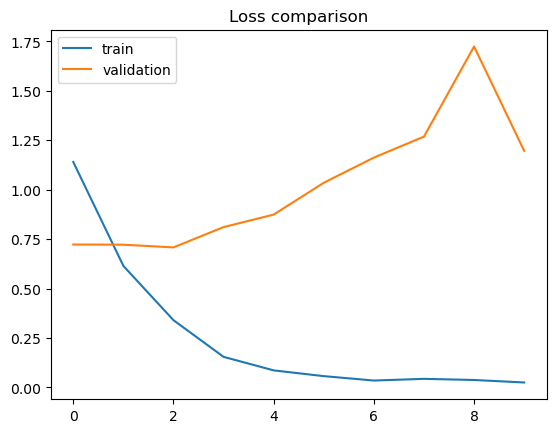

In [29]:
plt.title('Loss comparison')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

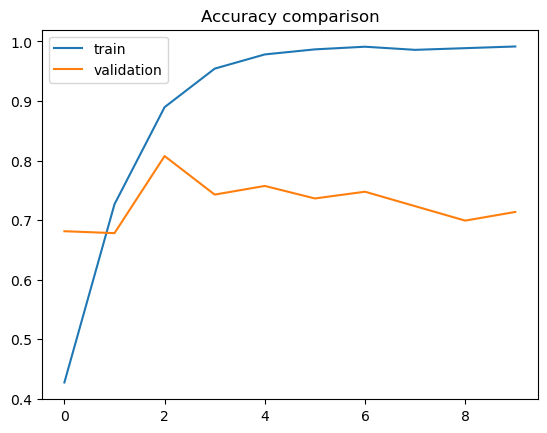

In [30]:
plt.title('Accuracy comparison')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show();

In [31]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

33/33 [==============================] - 17s 483ms/step - loss: 0.7298 - accuracy: 0.7963
Test Loss: 0.7297633290290833
Test Accuracy: 0.7963142395019531


In [32]:
y_test_final = best_model.predict(X_test_final, batch_size=batch_size)

21/21 [==============================] - 16s 738ms/step


In [33]:
print(y_test_final.shape)

(1288, 5)


In [34]:
print(np.argmax(y_test_final[0]))

3


In [35]:
y = np.argmax(y_test_final, axis=1)

# Preparing submission

In [36]:
submission = pd.read_csv('/kaggle/input/swahili-news-classification-v2/SampleSubmission.csv')

In [37]:
submission.columns = ['swahili_id', "Kitaifa"   ,"michezo"   ,"Biashara"   ,"Kimataifa"   ,"Burudani"]
submission.head()

,swahili_id,Kitaifa,michezo,Biashara,Kimataifa,Burudani
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,0,0,0,0,0
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,0,0,0,0,0
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,0,0,0,0,0
3,00868eeee349e286303706ef0ffd851f39708d37,0,0,0,0,0
4,00a5cb12d3058dcf2e42f277eee599992db32412,0,0,0,0,0


In [38]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   swahili_id  1288 non-null   object
 1   Kitaifa     1288 non-null   int64 
 2   michezo     1288 non-null   int64 
 3   Biashara    1288 non-null   int64 
 4   Kimataifa   1288 non-null   int64 
 5   Burudani    1288 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 60.5+ KB


In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   swahili_id  1288 non-null   object
 1   content     1288 non-null   object
dtypes: object(2)
memory usage: 20.2+ KB


In [40]:
print(np.sum(df_test['swahili_id'] == submission['swahili_id']))

1288


In [41]:
y_pred = np.argmax(y_test_final, axis=1)
print(y_pred.shape)

(1288,)


In [42]:
print(y_pred)

[3 4 0 ... 4 4 3]


In [43]:
for i, val in enumerate(y_pred):
    submission.iloc[i, int(val)+1] = 1
    #submission[val] = 1
    # print(i, val)

In [44]:
#submission = submission[['swahili_id', "Kitaifa"   ,"michezo"   ,"Biashara"   ,"Kimataifa"   ,"Burudani"]]
submission.head()

,swahili_id,Kitaifa,michezo,Biashara,Kimataifa,Burudani
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,0,0,0,1,0
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,0,0,0,0,1
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,1,0,0,0,0
3,00868eeee349e286303706ef0ffd851f39708d37,0,0,0,1,0
4,00a5cb12d3058dcf2e42f277eee599992db32412,0,0,0,1,0


In [45]:
submission.to_csv('submission.csv', index=False)